In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [2]:
# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
# from tqdm.notebook import tqdm  # Notebook-friendly tqdm
import time
import json
from glob import glob
from PIL import Image
import pickle
import tqdm

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

In [3]:
import glob

img_files = []
cap_list = []

with open('./words_captcha/spec_train_val.txt') as fin:
    for line in fin:
        image_name, caption = line.strip().split()
        img_files.append(f'./words_captcha/{image_name}.png')
        cap_list.append('<start> ' + ' '.join(caption) + ' <end>')

test_img_files = set(glob.glob(f'./words_captcha/*.png')) - set(img_files)
img_files += sorted(test_img_files)

print(img_files[0])
print(cap_list[0])

./words_captcha/a0.png
<start> t h u s <end>


In [45]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    oov_token=" ",
    filters=''  # Do not filter out any characters
)

tokenizer.fit_on_texts(cap_list)

# Convert the captions to sequences of character indices
train_seqs = tokenizer.texts_to_sequences(cap_list)

cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

def calc_max_length(tensor):
    return max(len(t) for t in tensor)
max_length = calc_max_length(cap_vector)

In [5]:
cap_vector[0]

array([ 2,  9, 18, 17,  6,  3,  0])

In [6]:
test_image_files = img_files[120000:]

img_name_train = img_files[:100000]
cap_train = cap_vector[:100000]

img_name_val = img_files[100000:120000]
cap_val = cap_vector[100000:120000]

In [7]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(100000, 100000, 20000, 20000)

In [8]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 10
BUFFER_SIZE = 5000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

### Build Dataset

In [9]:

def process_data(img_path, caption):
    img_tensor = preprocess_image(img_path)
    return img_tensor, caption

def preprocess_image(img_path):
    # Load the image from file
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)  # Decode JPEG with 3 color channels
    img = tf.image.resize(img, (224, 224))  # Resize image to required dimensions
    img = preprocess_input(img)  # Preprocess for a ResNet50 model
    return img

dataset_train = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
dataset_train = dataset_train.map(
    lambda img, cap: process_data(img, cap),
    num_parallel_calls=tf.data.AUTOTUNE  # Process multiple elements in parallel
)
dataset_train = dataset_train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)\
            .prefetch(buffer_size=tf.data.AUTOTUNE)
            
dataset_val = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))
dataset_val = dataset_val.map(
    lambda img, cap: process_data(img, cap),
    num_parallel_calls=tf.data.AUTOTUNE  # Process multiple elements in parallel
)
dataset_val = dataset_val.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)\
            .prefetch(buffer_size=tf.data.AUTOTUNE)

### Feature Extractor

In [10]:
efficientnet_model = EfficientNetB0(include_top=False, weights="imagenet", pooling="avg")

# print(efficientnet_model.summary())

### Encoder Decoder

In [11]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [12]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights
    
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [13]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [15]:
checkpoint_path = "./checkpoints/efficientnet"
ckpt = tf.train.Checkpoint(feature_extractor=efficientnet_model,
                           encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

In [16]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [ ]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    with tf.GradientTape() as tape:
        features = efficientnet_model(img_tensor, True)
        # print(features.shape)

        features = encoder(features)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables + efficientnet_model.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [ ]:
def postprocess(segs):
    output = []
    for seq in segs:
        result = ''
        for s in seq[1:]: 
            if s == tokenizer.word_index['<end>']:
                break
            s = s.numpy()
            result += tokenizer.index_word[s]
        output.append(result)
    return output


def eval_acc():
    sample_count = 0
    correct_count = 0
    for img_tensor, target in dataset_val:
        features = efficientnet_model(img_tensor)
        features = encoder(features)
        hidden = decoder.reset_state(batch_size=target.shape[0])
        dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)
        
        pred_list = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)
        real_list = []
        for i in range(max_length):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            predictions = tf.argmax(predictions, axis=1).numpy()
            dec_input = tf.expand_dims(predictions, 1)
            pred_list = tf.concat([pred_list, predictions.reshape((BATCH_SIZE, 1))], axis=1)
        
        pred_list = postprocess(pred_list)
        real_list = postprocess(target)
        # print(pred_list)
        # print(real_list)
        
        for pred, real in zip(pred_list, real_list):
            sample_count += 1
            if pred == real:
                correct_count += 1

    return correct_count / sample_count

In [68]:
EPOCHS = 10
start = time.time()

for epoch in range(start_epoch, EPOCHS):
    
    total_loss = 0
    pbar = tqdm.tqdm(enumerate(dataset_train), total=num_steps)
    for (batch, (img_tensor, target)) in pbar:
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        # acc = eval_acc()
        # print(f'Accuracy :{acc}')
        
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    
    acc = eval_acc()
    print(f'Accuracy :{acc}')
print ('Time taken for {} epoch {} sec\n'.format(EPOCHS, time.time() - start))

100%|██████████| 10000/10000 [12:36<00:00, 13.22it/s]


Epoch 1 Loss 1.532919
['sto', 'sto', 'sto', 'sto', 'sto', 'sto', 'sto', 'sto', 'sto', 'sto']
['quite', 'vhs', 'pdas', 'lil', 'mega', 'being', 'album', 'zope', 'gives', 'los']
['stsp', 'stsp', 'stsp', 'stsp', 'stsp', 'stsp', 'stsp', 'stsp', 'stsp', 'stsp']
['tax', 'ads', 'leave', 'job', 'sea', 'she', 'bike', 'noted', 'bible', 'thin']
['sts', 'sts', 'sts', 'sts', 'sts', 'sts', 'sts', 'sts', 'sts', 'sts']
['ind', 'geek', 'dicke', 'adsl', 'okay', 'till', 'reef', 'him', 'legs', 'dome']
['fana', 'fana', 'fana', 'fana', 'fana', 'fana', 'fana', 'fana', 'fana', 'fana']
['audi', 'demo', 'univ', 'tips', 'ati', 'grow', 'mhz', 'irc', 'most', 'fast']
['balarar', 'balarar', 'balarar', 'balarar', 'balarar', 'balarar', 'balarar', 'balarar', 'balarar', 'balarar']
['nam', 'coin', 'views', 'data', 'valid', 'logos', 'dip', 'sport', 'bay', 'pike']
['balarar', 'balarar', 'balarar', 'balarar', 'balarar', 'balarar', 'balarar', 'balarar', 'balarar', 'balarar']
['clark', 'meta', 'die', 'dui', 'pan', 'usual', 'we

100%|██████████| 10000/10000 [12:49<00:00, 13.00it/s]


Epoch 2 Loss 1.489309
['finabe', 'finabe', 'finabe', 'finabe', 'finabe', 'finabe', 'finabe', 'finabe', 'finabe', 'finabe']
['risk', 'tape', 'enjoy', 'idol', 'soap', 'skill', 'bra', 'font', 'every', 'ask']
['fin', 'fin', 'fin', 'fin', 'fin', 'fin', 'fin', 'fin', 'fin', 'fin']
['nav', 'lady', 'hurt', 'stem', 'burn', 'sim', 'egg', 'hold', 'max', 'plate']
['flon', 'flon', 'flon', 'flon', 'flon', 'flon', 'flon', 'flon', 'flon', 'flon']
['fin', 'usc', 'mac', 'ser', 'dans', 'thank', 'cdt', 'iso', 'dance', 'posts']
['serm', 'serm', 'serm', 'serm', 'serm', 'serm', 'serm', 'serm', 'serm', 'serm']
['leon', 'alex', 'buzz', 'aid', 'dash', 'paper', 'neck', 'when', 'major', 'lol']
['conerin', 'conerin', 'conerin', 'conerin', 'conerin', 'conerin', 'conerin', 'conerin', 'conerin', 'conerin']
['leg', 'pike', 'japan', 'north', 'sad', 'cycle', 'flu', 'add', 'hack', 'coal']
['serints', 'serints', 'serints', 'serints', 'serints', 'serints', 'serints', 'serints', 'serints', 'serints']
['cal', 'gets', 'out', 

KeyboardInterrupt: 

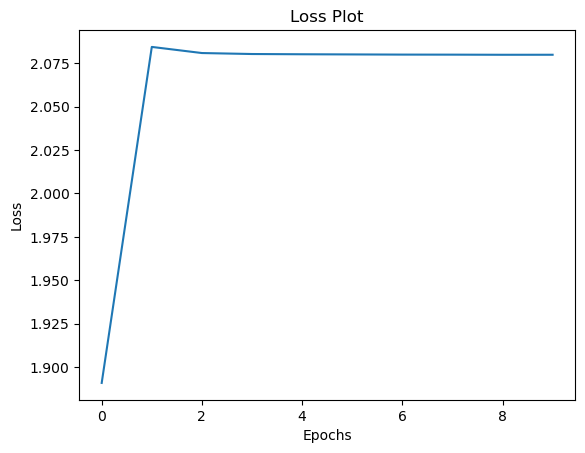

In [28]:
import matplotlib.pyplot as plt

plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
ckpt = tf.train.Checkpoint(feature_extractor=efficientnet_model,
                           encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt.restore('./checkpoints/efficientnet/ckpt-10')

In [ ]:
dataset_test = tf.data.Dataset.from_tensor_slices((test_image_files))
dataset_test = dataset_test.map(
    lambda img: preprocess_image(img),
    num_parallel_calls=tf.data.AUTOTUNE  # Process multiple elements in parallel
)
dataset_test = dataset_test.batch(BATCH_SIZE, drop_remainder=True)\
            .prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
import re

with open('./Lab12-2_113062503.txt', 'w') as fout:
    for step, (img_tensor, img_path) in enumerate(tqdm(dataset_test)):
        predict = []
        features = efficientnet_model(img_tensor)
        features = encoder(features)
        hidden = decoder.reset_state(batch_size=img_tensor.shape[0])
        dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)
        for i in range(max_length):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            predictions = tf.argmax(predictions, axis=1)
            dec_input = tf.expand_dims(predictions, 1)
            predict.append(predictions)
        
        pred_list = postprocess(predict.numpy())
        for path, pred in zip(img_path, pred_list):
            path = path.numpy().decode('utf-8')
            name = re.search('(a[0-9]+)', path).group(1)
            fout.write(f'{name} {pred}\n')